# Ethan's CCS Calculator ⏱️




---



A CCS (Composite Current Source) model is basically the EDA industries way of coping with tiny wires on nodes smaller than 90nm. At that scale the exsiting model called NLDM breaks down :(.

CCS is part of the [liberty](https://media.c3d2.de/mgoblin_media/media_entries/659/Liberty_User_Guides_and_Reference_Manual_Suite_Version_2017.06.pdf) specification, but how you do the actual calculation is not well documented.


# **Setup**

In [ ]:
!wget https://github.com/The-OpenROAD-Project/asap7/raw/master/asap7sc7p5t_28/LIB/CCS/asap7sc7p5t_SIMPLE_LVT_SS_ccs_211120.lib.gz && gunzip asap7sc7p5t_SIMPLE_LVT_SS_ccs_211120.lib.gz

## Spice Setup

In [ ]:
!git clone git://git.code.sf.net/p/ngspice/ngspice


In [ ]:
!sudo apt-get install autoconf automake libtool cmake autoconf-archive libxaw7-dev bison flex

In [ ]:
%%shell

cd ngspice
autoreconf --install
mkdir -p release
cd release
pwd
../configure \
  --prefix=/usr/local \
  --enable-xspice \
  --disable-debug \
  --enable-cider \
  --with-readline=yes \
  --enable-openmp \
  --with-ngshared

 make # -j4
 sudo make install

 cd ..

In [ ]:
!pip3 install liberty-parser PySpice


# CCS Data Model

## CCS Data Extraction

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [ ]:
from liberty.parser import parse_liberty

# Read and parse a library.
library = parse_liberty(open("asap7sc7p5t_SIMPLE_LVT_SS_ccs_211120.lib").read())


### Liberty Extraction

Below we extract the CCS table for the rising input of and AND2 gate, between the A *(input)* and Y *(output pin)*:



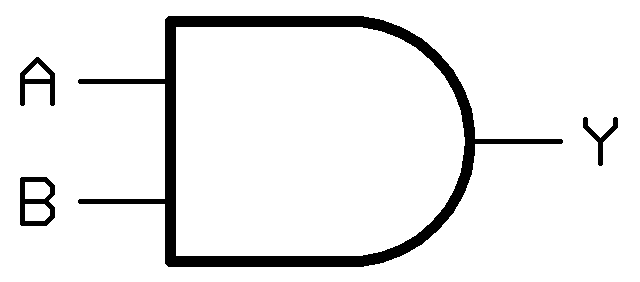
---



In [ ]:
import numpy as np
import math

cells = library.get_groups('cell')
and_2x2 = [cell for cell in cells if cell.args[0] == "AND2x2_ASAP7_75t_L"][0]
output_pin_named_Y = [pin for pin in and_2x2.get_groups('pin') if pin.args[0] == "Y"][0]
timing_info = [time for time in output_pin_named_Y.get_groups('timing') if time["related_pin"] == "A"][0]
output_current_rise = timing_info.get_group('output_current_rise')
output_current_rise_vectors = output_current_rise.get_groups('vector')


ccs_table = {}
and_vector_table_inputs = np.array([]).reshape(0,3)
and_vector_table_value = np.array([])


for vector in output_current_rise_vectors:
  # This should be based on the output_current_template (ccs_template) group
  # struct, but I'm being lazy.
  #   output_current_template (ccs_template) {
  #     variable_1 : input_net_transition;
  #     variable_2 : total_output_net_capacitance;
  #     variable_3 : time;
  #   }
  input_net_transition = vector.get_array('index_1')[0]
  total_output_net_capacitance = vector.get_array('index_2')[0]
  times = vector.get_array('index_3')[0]
  original_values = vector.get_array('values')[0]
  values = np.concatenate((np.array([0]), original_values))

  ccs_table[total_output_net_capacitance[0]] = ccs_table.get(total_output_net_capacitance[0], {})
  ccs_table[total_output_net_capacitance[0]][input_net_transition[0]] = (times, original_values)

  #Zip together all the input values.
  input_array = []
  for slew in input_net_transition:
    for cap in total_output_net_capacitance:
      input_array.append([0, cap, slew])
      for time in times:
        input_array.append([time, cap, slew])
  
  and_vector_table_inputs = np.concatenate((and_vector_table_inputs, np.array(input_array)))
  and_vector_table_value = np.concatenate((and_vector_table_value, values))
  


### CCS Sample Table AND Gate

The follow chart is a table of the slew capactiance curves. Each curve is a measure of the current over time. The curve starts from the moment the voltage between the gate and a load capacitor. Each curve measure the current in mA over time and ends once the voltage reaches V_high or Vdd (The peak voltage). If this transition was falling instead of rising you would have a negative current and the voltage would start from Vdd and fall to 0

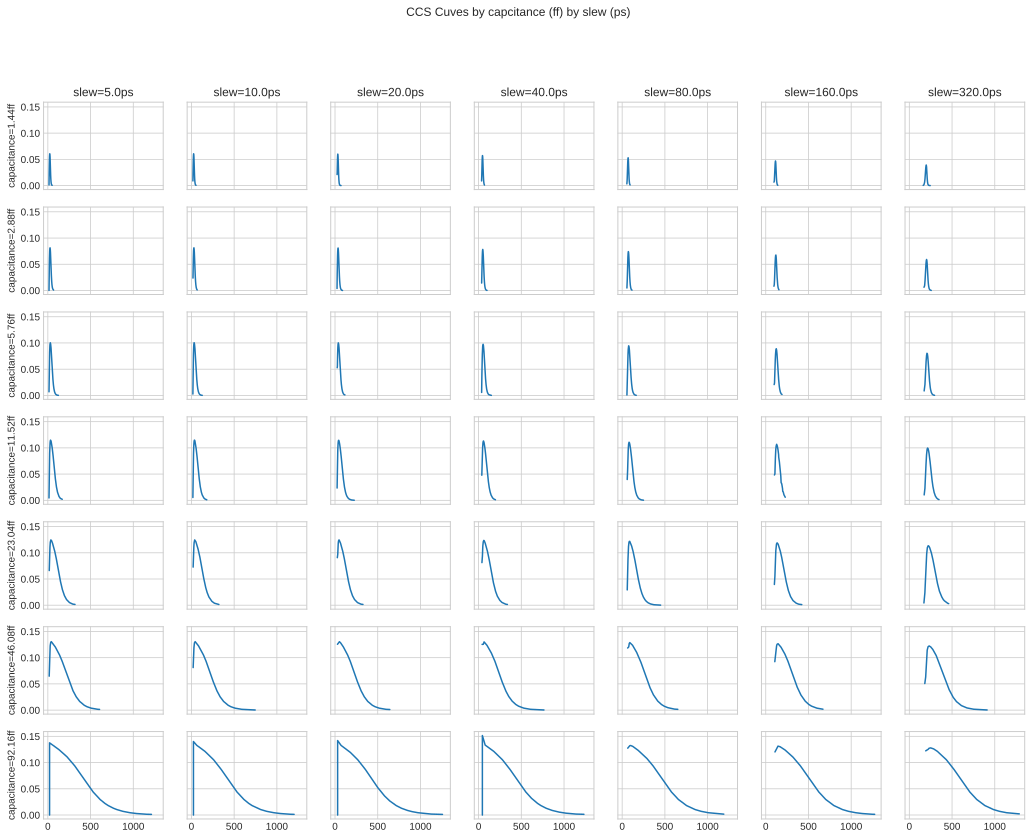

In [ ]:
%config InlineBackend.figure_format = 'svg'

table_length_and_width = int(math.sqrt(len(output_current_rise_vectors)))

fig, axs = plt.subplots(table_length_and_width, table_length_and_width, sharex=True, sharey= True)
width = 8 * 2.2
height = 6 * 2.2
fig.set_size_inches(width, height)
fig.suptitle('CCS Cuves by capcitance (ff) by slew (ps)')


i = 0
for total_cap, slew_table in sorted(ccs_table.items()):
  j = 0
  for slew, curve in sorted(slew_table.items()):
    if i == 0:
      axs[i, j].set_title("slew={}ps".format(slew))
    if j == 0:
      axs[i, j].set(ylabel = "capacitance={}ff".format(total_cap))
    axs[i, j].plot(curve[0], curve[1])
    j = j+1
  i = i+1




### Example Curve

A curve from the 11.52ff load capacitor at 160ps of slew.

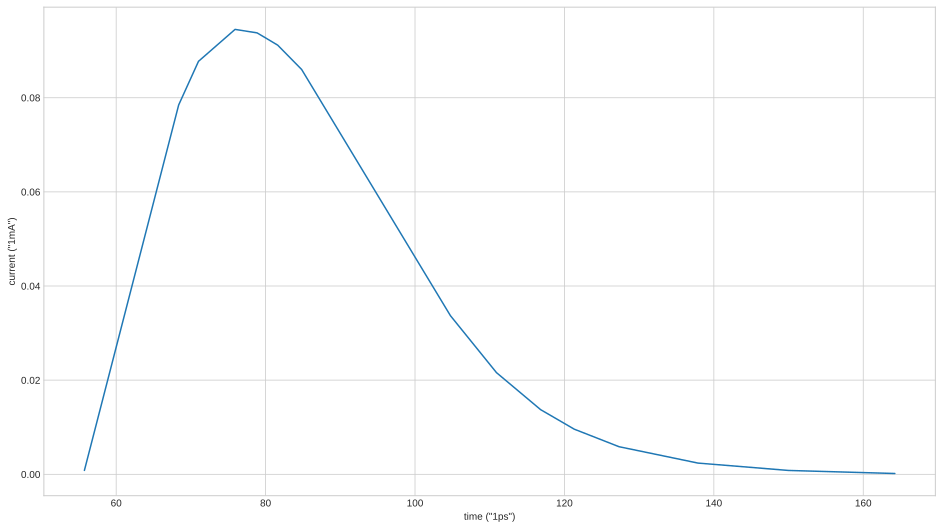

In [ ]:
%config InlineBackend.figure_format = 'svg'

time = ccs_table[5.76][80.0][0]
current = ccs_table[5.76][80.0][1]

fig = plt.figure()
ax = plt.axes()

plt.xlabel("time ({})".format(library.get_attribute("time_unit")))
plt.ylabel("current ({})".format(library.get_attribute("current_unit")))

ax.plot(time, current)

## Interpolation

As you can see above the CCS data model is sparse there's only a few reference values provided from the underlying spice simulation data. The CCS calculator may run into a number of slews and load capacitances that might not be in the underlying data.

Therefore a big part of the CCS model is to figure out how to interpolate the data accurately.

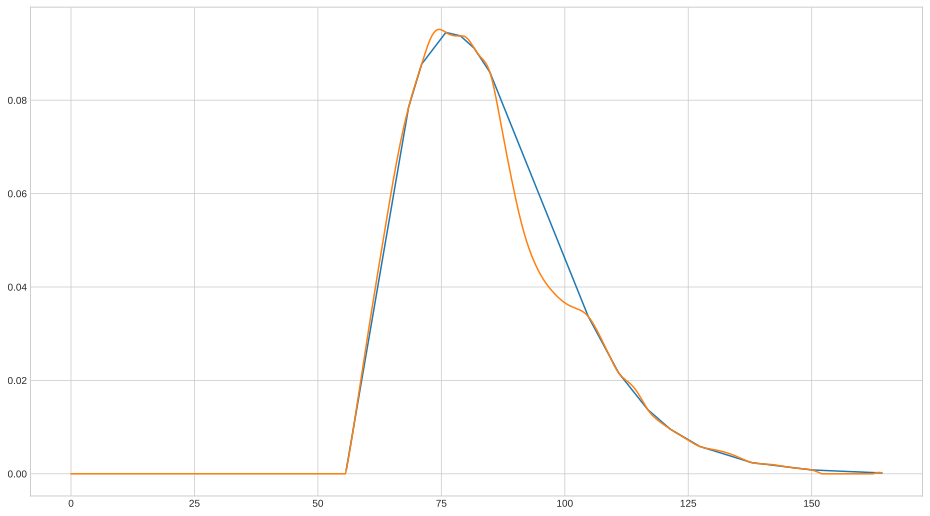

In [ ]:
import scipy.interpolate

rbf_interpolation = scipy.interpolate.RBFInterpolator(and_vector_table_inputs, and_vector_table_value, kernel='multiquadric', epsilon=0.5)
fine_time = np.linspace(0, time[-1], 1000)

data_inputs = []

for time_f in fine_time:
  data_inputs.append([time_f, 5.76 , 80])

data_inputs = np.array(data_inputs)
fine_current = rbf_interpolation(data_inputs)
fine_current = np.clip(fine_current, a_min = 0, a_max = None)



fig = plt.figure()
ax = plt.axes()

ax.plot(time, current)
ax.plot(fine_time, fine_current)

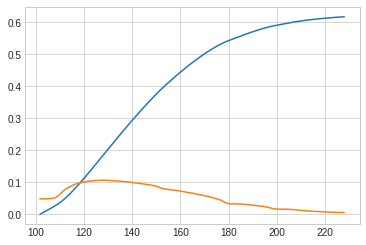

In [ ]:

current = scipy.interpolate.PchipInterpolator(time, current, extrapolate = True)
voltage = current.antiderivative()

fig = plt.figure()
ax = plt.axes()

fine_time = np.linspace(time[0], time[-1], 1000)
ax.plot(fine_time, np.multiply(voltage(fine_time), 1/11.52))
ax.plot(fine_time, current(fine_time))


# Dino's notes on Feldmann et al., "Driver Waveform Computation for Timing Analysis with Multiple Voltage Threshold Driver Models", 2008

Link to paper: https://ieeexplore.ieee.org/document/4555855attempted 

The paper says it is straightforward to derive the charge Eq. (7) but I found it very tedious and unclear and I couldn't yet derive the same terms as in the paper. Here's how I tried it:

We have the admittance matrix of a general transmission-line receiver in the Laplace-domain
$$ 
Y(s) = k_{-1} s + k_0 + \sum_{j=1}^N \frac{k_j}{1+ s d_j} 
$$
and we want to calculate the total charge flowing into the receiver, i.e. into the admittance $Y$ as
$$
\int_0^{T_l} i_o(t) dt = \sum_{j = -1}^N Q_{j, l}.
$$
In order to do that, we will break apart the whole integral into intervals
$$
\int_0^{T_l} i_o(t) dt = \sum_{i=0}^{l-1} \int_{T_i}^{T_{i+1}} i_o(t) dt  
$$
and then calculate the contribution of each interval separately.

To this end, we start with the current in the Laplace domain
$$
I(s) = Y(s) V(s)
$$
and apply the inverse Laplace transform for each term separately. The first term is  (TODO: figure out what happens to the constant term here...)
$$
k_{-1} s V(s)
\overset{\mathcal{L}^{-1}}{\longrightarrow} k_{-1} \frac{d}{dt} v(t).
$$
The second term reads
$$
k_0 V(s) \overset{\mathcal{L}^{-1}}{\longrightarrow} k_0 v(t),
$$
and the third term reads
$$
\frac{k_j}{1+sd_j}V(s)
\overset{\mathcal{L}^{-1}}{\longrightarrow}
\frac{k_j}{d_j}\int_0^t dt' e^{-\frac{t-t'}{d_j}}v(t'),
$$
where we used several known identities of the Laplace transform -- including the convolution theorem in the third term.

For each time-interval, we can now solve $\int i_o dt$ assuming the potential varies linearly over the interval, i.e.
$$
v(t) = \frac{V_{l+1} - V_{l}}{T_{l+1} - T_{l}}( t - T_l) + V_l 
\quad\text{if} \quad T_l \le t < T_{l+1}.
$$
For the first term we find
$$
I_1 := \int_{T_l}^{T_{l+1}} dt\; \left(k_{-1} \frac{d}{dt}v(t)\right)
= k_{-1} (V_{l+1} - V_l).
$$

The second term reads
$$
I_2 := \int_{T_l}^{T_{l+1}} dt\; k_{0} v(t)
=\frac12 k_0 (V_{l+1} + V_{l})(T_{l+1}- T_l).
$$

And the third term yields (Note: It could be wrong to do the integration from $0$ to $t$ only over the piecewise linear potential part between $T_l$ and $T_{l+1}$.
$$
\begin{split}
I_3 := \int_{T_l}^{T_{l+1}} dt\; &\frac{k_j}{d_j}\int_0^t dt' e^{-\frac{t-t'}{d_j}}v(t')\\
={}& \frac{k_j}{d_j}\int_{T_l}^{T_{l+1}} dt\; \int_0^t dt'\; e^{t'/d_j}
  \left(\frac{V_{l+1} - V_{l}}{T_{l+1} - T_{l}}( t' - T_l) + V_l\right),
\end{split}
$$
which contains the two following integrals:
$$
\begin{split}
\int_{T_l}^{T_{l+1}} dt \int_0^t dt'\; t' e^{t'/d_j}
={}& \int_{T_l}^{T_{l+1}} dt \left(d_j t\,e^{t/d_j}-d_j^2 e^{t/d_j} + d_j^2\right)\\
={}& \bigg[d_j^2 t e^{t/d_j} - d_j^3 e^{t/d_j} - d_j^3 e^{t/d_j} + d_j^2 t\bigg]_{t=T_l}^{T_{l+1}}\\
={}& d_j^2\left(T_{l+1} e^{T_{l+1}/d_j} - T_{l} e^{T_{l}/d_j}\right)
  - 2 d_j^3 \left(e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
  + d_j^2\left(T_{l+1} - T_l\right)
\end{split}
$$
and
$$
\begin{split}
\int_{T_l}^{T_{l+1}} dt \int_0^t dt' e^{t'/d_j}
={}& \int_{T_l}^{T_{l+1}} dt \left(d_j e^{t/d_j}-d_j\right)
= \bigg[d_j^2 e^{t/d_j} - d_j t\bigg]_{t=T_l}^{T_{l+1}}\\
={}& d_j^2\left( e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
  - d_j\left(T_{l+1} - T_l\right).
\end{split}
$$
Inserting these integrals into $I_3$, we obtain
$$
\begin{split}
I_3 ={}& \frac{k_j}{d_j}\frac{V_{l+1} - V_{l}}{T_{l+1} - T_{l}}
  \left[
  d_j^2\left(T_{l+1} e^{T_{l+1}/d_j} - T_{l} e^{T_{l}/d_j}\right)
  - 2 d_j^3 \left(e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
  + d_j^2\left(T_{l+1} - T_l\right)
  - T_l\left(d_j^2\left( e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
  - d_j\left(T_{l+1} - T_l\right)\right)
  \right]\\
  & + \frac{k_j}{d_j}V_{l}
    \left[
      d_j^2\left( e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
      - d_j\left(T_{l+1} - T_l\right)
    \right]\\
={}& k_j\frac{V_{l+1} - V_{l}}{T_{l+1} - T_{l}}
  \left[
  d_j e^{T_{l+1}/d_j} \left(T_{l+1} -T_l\right)
  - 2 d_j^2 \left(e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
  + d_j\left(T_{l+1} - T_l\right)
  + T_l\left(T_{l+1} - T_l\right)
  \right]\\
  & + k_jV_{l}
    \left[
      d_j\left( e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
      -\left(T_{l+1} - T_l\right)
    \right]\\
={}& k_j d_j(V_{l+1} - V_{l})
  \left[1 +
      e^{T_{l+1}/d_j}
    - \frac{2 d_j}{T_{l+1} - T_{l}}\left(e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right) 
  \right]\\
  & + k_jd_j V_{l}\left( e^{T_{l+1}/d_j} - e^{T_{l}/d_j}\right)
   + k_j T_l (V_{l+1} - V_{l}) - k_j V_l \left(T_{l+1} - T_l\right)\\
={}&
    k_j d_j(V_{l+1} - V_{l})e^{T_{l+1}/d_j}
    \left[ 
        1 - \frac{2 d_j}{T_{l+1} - T_{l}}\left(1 - e^{- \frac{T_{l+1} - T_{l}}{d_j}}\right)
    \right]
  + k_jd_j V_{l}e^{T_{l+1}/d_j} \left( 1 -e^{- \frac{T_{l+1} - T_{l}}{d_j}}\right)\\
  & + k_j d_j (V_{l+1} - V_{l}) 
  + k_j \left(T_l V_{l+1} - V_l T_{l+1}\right).
\end{split}
$$


This looks quite close to the equation after Eq. (7) in the paper but still different. What am I missing?

